In [294]:
import sys
print(sys.executable)

/Users/zeyuli/anaconda3/envs/ECE661_HW/bin/python


In [295]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

x1, y1 = np.array([ 1, -2, -1, -1,  1]), 7
x2, y2 = np.array([ 2, -1,  2,  0, -2]), 1
x3, y3 = np.array([-1,  0,  2,  2,  1]), 1

x_input = np.array([x1, x2, x3]).reshape(3, 5)
y_input = np.array([y1, y2, y3])

w0 = np.zeros(5).reshape(-1, 1)
mu = 0.02
n_epochs = 200
print(x_input, y_input)

LEGEND_size = 7
TITLE_size = 12
AXLABEL_size = 9
TICK_size = 8

[[ 1 -2 -1 -1  1]
 [ 2 -1  2  0 -2]
 [-1  0  2  2  1]] [7 1 1]


In [296]:
def my_relu(a):
    return np.abs(a) * (a > 0)


def l1_norm_trimmed_update(in_x, in_y, w_prev, l1_reg_param, lr, thresh):
    """
    thresh: number of elements to keep unchanged when performing proximal l1
    """
    ascend_idx = np.argsort(np.abs(w_prev.flatten()))
    weight_l1_proximal = l1_norm_proximal_update(in_x, in_y, w_prev, l1_reg_param, lr,
                                                 which_weights=ascend_idx[0:w_prev.shape[0] - thresh])
    return weight_l1_proximal


def l1_norm_proximal_update(in_x, in_y, w_prev, l1_reg_param, lr, which_weights=None):
    """
    Computes weight using proximal gradient descent (l1-norm). threshold is l1_reg_param*lr
    Args:
        in_x: x values (data)
        in_y: y values (target)
        w_prev: previous weight
        l1_reg_param: l1 regularisation (lambda)
        lr: learning rate, must be not None.
        which_weights: indices of which weights for which proximal update is applied
    Note: threshold = lr * lambda should be in set{0.004, 0.01, 0.02, 0.04}
    Returns: updated weight
    """
    if which_weights is None:
        which_weights = np.array(range(len(w_prev.flatten())))
        # which_weights = [0,1,2,3,4] if w_prev.shape == (5, 1)
    weight_tilde = no_regularisation_update(in_x, in_y, w_prev, lr=lr) # main objective
    weight_ret = np.copy(weight_tilde)

    threshold = lr * l1_reg_param
    assert threshold >= 0

    for iii in which_weights:  # only updates the weights specified in which_weights
        this_weight = weight_tilde[iii, 0]
        weight_ret[iii, 0] = my_relu(np.abs(this_weight) - threshold) * np.sign(this_weight)
    return weight_ret


def l1_norm_update(in_x, in_y, w_prev, l1_reg_param, lr):
    """
    Args:
        in_x: x values (data)
        in_y: y values (target)
        w_prev: previous weight
        l1_reg_param: l1 regularisation (lambda)
        lr: learning rate, must be not None
    Returns: updated weight
    """
    grad = no_regularisation_update(in_x, in_y, w_prev, l1_reg_param, lr=None) + \
           l1_reg_param * np.sign(w_prev)
    assert grad.shape == w_prev.shape
    return w_prev - lr * grad


def no_regularisation_update(in_x, in_y, w_prev, l1_reg_param=None, lr=None):
    """
    Args:
        in_x: x values (data)
        in_y: y values (target)
        w_prev: previous weight
        l1_reg_param: dummy
        lr: if None, it means some fn other than run_grad_descent called it; if run_grad_descent called it,
        must be (not None)
    Returns: returns updated weight if lr is not None; returns gradient if lr is None
    """
    n_r, n_c = in_x.shape
    grad = 0
    for inner in range(n_r):
            grad += 2 * (np.dot(in_x[inner, :], w_prev) - in_y[inner]) * in_x[inner].reshape(-1, 1)
    if lr is not None:
        return w_prev - lr * grad
    else:
        return grad


def run_grad_descent(w_init, lr, in_x, in_y, epochs, w0_prune=False, thresh=None, l1_reg_param=None,
                     grad_fn=no_regularisation_update) -> Tuple[np.array, np.array, np.array]:
    """
    Args:
        w_init: w0 = np.zeros(5)
        lr: mu=0.02
        in_x: x1, x2, x3
        in_y: y1, y2, y3
        epochs: 200
        w0_prune: prune or not (lab 1 c). should be False in all except for lab 1c
        thresh: threshold for pruning or trimmed l1. should be True only in lab 1 c, lab 1 f
        l1_reg_param: lambda, used in update weight
        grad_fn: function for updating weight
    Returns: optimal weight (np.array), loss for each epoch (np.array), and w_arr matrix to
    record the progression of each weight through time
    """
    w_prev = w_init
    l_arr = []
    w_arr = np.zeros((len(w_init), epochs))
    n_r, n_c = in_x.shape
    for i in range(epochs):
        if not w0_prune and thresh is not None:  # only for lab 1 f, l1-trimmed
            w_curr = grad_fn(in_x, in_y, w_prev, l1_reg_param, lr=lr, thresh=thresh)
        else:
            w_curr = grad_fn(in_x, in_y, w_prev, l1_reg_param, lr=lr)

        if w0_prune and thresh is not None:  # only for lab 1 c, pruning
            w_curr_sorted_idx = np.argsort(np.abs(w_curr.flatten()))  # sort ascending
            for inner in range(len(w_init) - thresh):
                # len(w_init) - thresh = 5 - 2 = 3, so three smallest weights (absolute value) are
                # forced to zero
                w_curr[w_curr_sorted_idx[inner], 0] = 0  # zero-ing out smallest elements
        l_curr = 0
        for inner in range(n_r):
            l_curr += (np.dot(in_x[inner, :], w_curr) - in_y[inner]) ** 2
        l_arr.append(l_curr)
        w_arr[:, i] = w_curr.flatten()
        w_prev = w_curr
    return w_prev, np.array(l_arr), w_arr


def plot_log_loss_vs_n_iters(num_epochs, loss_array, save_name_, save=False,
                             plt_axis=None):
    if plt_axis is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig, ax = None, plt_axis
    ax.semilogy(range(num_epochs), loss_array, label='Lowest loss=%g' % np.min(loss_array))
    ax.set_xlabel('Number of Iterations', fontsize=AXLABEL_size)
    ax.set_ylabel('L (log10 scale)', fontsize=AXLABEL_size)
    ax.set_title('Loss vs Number of Iterations', fontsize=TITLE_size)
    ax.tick_params(axis='both', labelsize=TICK_size)
    ax.legend(loc='best', fontsize=LEGEND_size)
    if fig is not None:
        fig.tight_layout()
    if save:
        plt.savefig('%s.pdf' % save_name_, dpi=700, bbox_inches='tight')


def plot_weight_val_vs_n_iters(num_epochs, w_init, final_weights, weight_array, save_name_, save=False,
                               plt_axis=None):
    if plt_axis is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig, ax = None, plt_axis
    line_styles = ['-', ':', '--', '-.', (0, (1, 1))]
    for iii in range(len(w_init)):
        ax.plot(range(num_epochs), weight_array[iii, :], linestyle=line_styles[iii],
                linewidth=1., label='final value %.5f' % final_weights[iii])
    ax.legend(loc='best', fontsize=LEGEND_size)
    ax.tick_params(axis='both', labelsize=TICK_size)
    ax.set_xlabel('Number of Iterations', fontsize=AXLABEL_size)
    ax.set_ylabel('Value of Weights', fontsize=AXLABEL_size)
    ax.set_title('Weight Values vs Number of Iterations', fontsize=TITLE_size)
    if fig is not None:
        fig.tight_layout()
    if save:
        plt.savefig('%s.pdf' % save_name_, dpi=700, bbox_inches='tight')


def plot_many_w_vals_or_loss_vs_n_iters(num_epochs, w_init, l1_reg_params, save_name_, save=False,
                                    loss_arr_lst=None, final_weights_list=None, weight_array_list=None):
    """
    Args:
        num_epochs: number of iterations (200)
        w_init: initial weights
        final_weights_list: list of weights achieved by gradient descent by default None
        weight_array_list: list of np array that describe weight progression by default None
        loss_arr_lst: list of loss arrays (len(loss_arr_lst) corresponds to len(l1_reg_params))
        by default, loss_arr_lst=None. If not None,
        l1_reg_params: reg params (lambda)
        save_name_: name of file
        save: save or not
    Either (final_weights_list and weight_array_list are not None) or (loss_arr_lst is not None)
    Returns: None
    """
    assert (final_weights_list is not None and weight_array_list is not None) or \
        loss_arr_lst is not None, \
        "Either (final_weights_list and weight_array_list are not None) or (loss_arr_lst is not None)"
    assert not (final_weights_list is not None and weight_array_list is not None and
        loss_arr_lst is not None), "all three are not None."
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    ax_flat = ax.flatten()
    for iii, axis in enumerate(ax_flat):
        if loss_arr_lst is None:
            plot_weight_val_vs_n_iters(num_epochs, w_init, final_weights=final_weights_list[iii],
                                       weight_array=weight_array_list[iii], save_name_=None, save=False,
                                       plt_axis=axis)
        else:
             plot_log_loss_vs_n_iters(num_epochs, loss_array=loss_arr_lst[iii], save_name_=None,
                                      save=False, plt_axis=axis)
        ax_flat[iii].set_title("lambda=%g" % l1_reg_params[iii])
    if fig is not None:
        fig.tight_layout()
    if save_name_ is not None and save:
        plt.savefig('%s.pdf' % save_name_, dpi=700, bbox_inches='tight')
    return

In [297]:
""" part b (3 pts) In Python, directly minimize the objective L without any sparsity-inducing regularisation/constraint. Plot the value of log(L) vs. #steps throughout the training, and use another figure to plot how the value of each element in W is changing throughout the training. From your result, is W converging to an optimal solution? Is W converging to a sparse solution?
"""
weight, loss_arr, weight_arr = run_grad_descent(w0, mu, x_input, y_input, epochs=n_epochs)
print(weight.shape, loss_arr.shape, weight_arr.shape)

(5, 1) (200, 1) (5, 200)


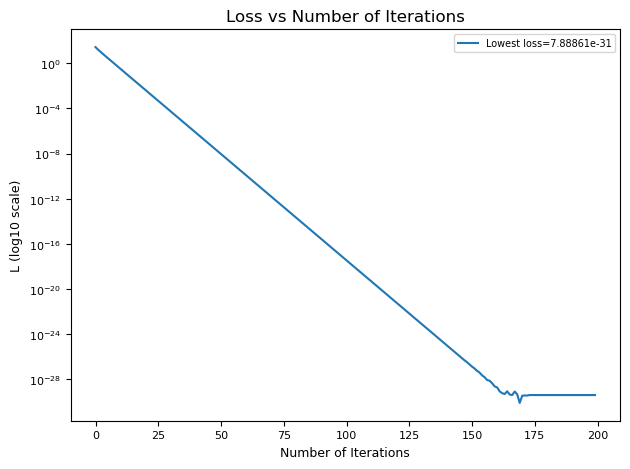

In [298]:
# part b
plot_log_loss_vs_n_iters(num_epochs=n_epochs, loss_array=loss_arr, save_name_='lab1b_loss', save=True)

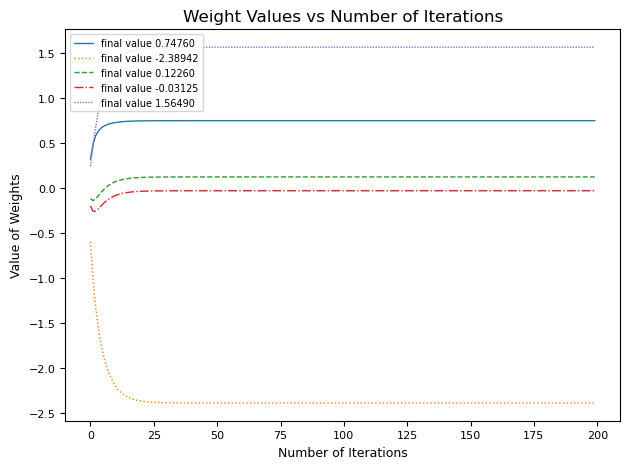

In [299]:
# part b
plot_weight_val_vs_n_iters(num_epochs=n_epochs, w_init=w0, final_weights=weight,
                           weight_array=weight_arr, save_name_='lab1b_weights', save=True)

In [300]:
"""part (c) (6 pts) Since we have the knowledge that the ground-truth weight should have ||W||0 ≤ 2, we can apply projected gradient descent to enforce this sparse constraint. Redo the optimization process in (b), this time prune the elements in W after every gradient descent step to ensure ||W^l||0 ≤ 2. Plot the value of log(L) throughout the training, and use another figure to plot the value of each element in W in each step. From your result, is W converging to an optimal solution? Is W converging to a sparse solution?"""
weight_pruned, loss_arr_pruned, weight_arr_pruned = \
    run_grad_descent(w0, mu, x_input, y_input, n_epochs, w0_prune=True, thresh=2)

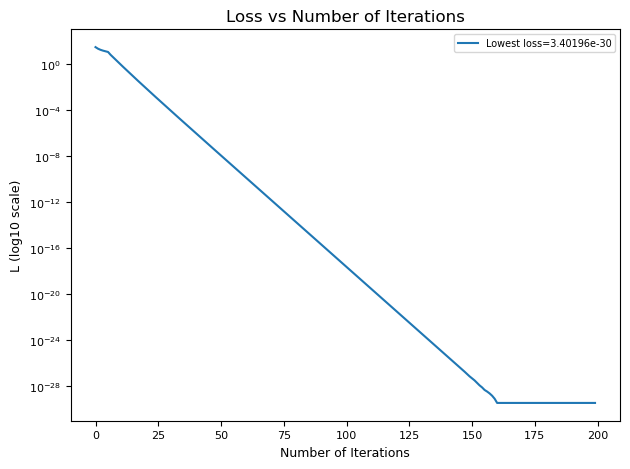

In [301]:
plot_log_loss_vs_n_iters(num_epochs=n_epochs, loss_array=loss_arr_pruned, save_name_='lab1c_loss',
                         save=True)

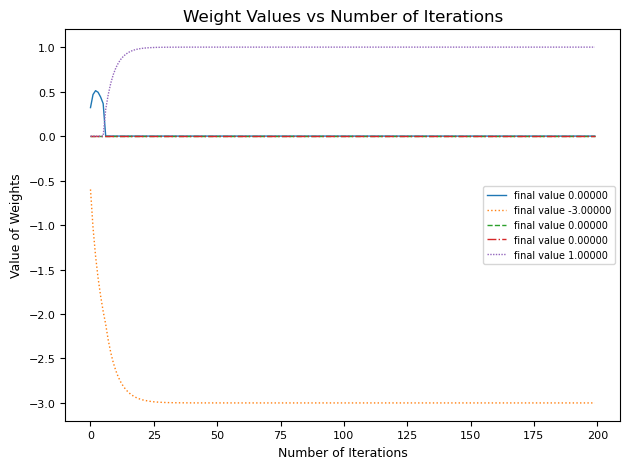

In [302]:
# part c
plot_weight_val_vs_n_iters(num_epochs=n_epochs, w_init=w0, final_weights=weight_pruned,
                           weight_array=weight_arr_pruned, save_name_='lab1c_weights', save=True)

In [303]:
"""part (d) (5 pts) In this problem we apply l1 regularization to induce the sparse solution. The minimization objective therefore changes to L + lambda||W||_1. Please use full-batch gradient descent to minimize this objective, with lambda = {0.2, 0.5, 1.0, 2.0} respectively. For each case, plot the value of log(L) throughout the training, and use another figure to plot the value of each element in W in each step. From your result, comment on the convergence performance under different lambda."""

lambda_list = [0.2, 0.5, 1.0, 2.0]
weight_l1_list, loss_l1_list, weight_arr_l1_list = [], [], []
for idx, lll in enumerate(lambda_list):
    weight_l1, loss_arr_l1, weight_arr_l1 = run_grad_descent(w0, mu, x_input, y_input, n_epochs,
                                                             w0_prune=False, thresh=None,
                                                             l1_reg_param=lambda_list[idx],
                                                             grad_fn=l1_norm_update)
    weight_l1_list.append(weight_l1)
    loss_l1_list.append(loss_arr_l1)
    weight_arr_l1_list.append(weight_arr_l1)


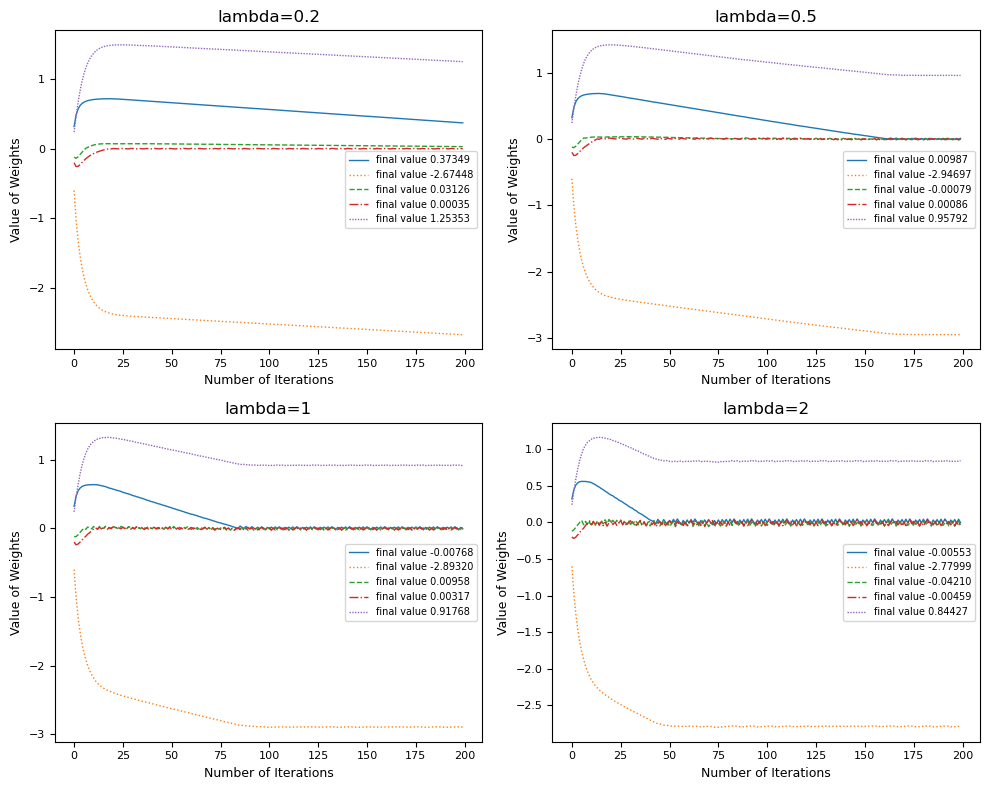

In [304]:
plot_many_w_vals_or_loss_vs_n_iters(num_epochs=n_epochs, w_init=w0, final_weights_list=weight_l1_list,
                                    weight_array_list=weight_arr_l1_list, loss_arr_lst=None,
                                    l1_reg_params=lambda_list, save_name_='lab1d_weight', save=True)

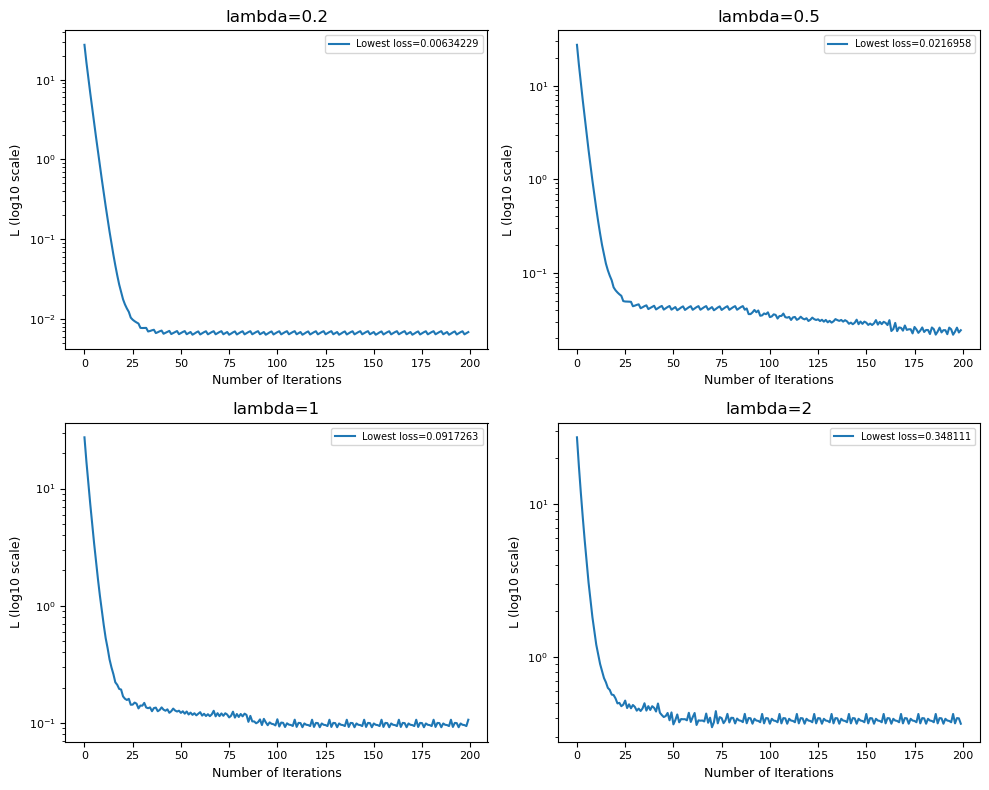

In [305]:
plot_many_w_vals_or_loss_vs_n_iters(num_epochs=n_epochs, w_init=w0, final_weights_list=None,
                                    weight_array_list=None, loss_arr_lst=loss_l1_list,
                                    l1_reg_params=lambda_list, save_name_='lab1d_loss', save=True)

In [306]:
"""
part (e) (6pts) Here we optimize the same objective as in (d), this time using proximal gradient update. Recall that the proximal operator of the l1 regulariser is the soft thresholding function. Set the threshold in the soft thresholding function to {0.004, 0.01, 0.02, 0.04} respectively. Plot the value of log(L) throughout the training, and use another figure to plot the value of each element in W in each step. Compare the convergence performance with the results in (d). (Hint: Optimizing L + lambda||W||_1 using gradient descent with learning rate mu should correspond to proximal gradient update with threshold mu*lambda)"""

lambda_list = [0.2, 0.5, 1.0, 2.0]
weight_prox_list, loss_prox_list, weight_arr_prox_list = [], [], []
for idx, lll in enumerate(lambda_list):
    weight_prox, loss_arr_prox, weight_arr_prox = run_grad_descent(w0, mu, x_input, y_input, n_epochs,
                                                                   w0_prune=False, thresh=None,
                                                                   l1_reg_param=lll,
                                                                   grad_fn=l1_norm_proximal_update)
    weight_prox_list.append(weight_prox)
    loss_prox_list.append(loss_arr_prox)
    weight_arr_prox_list.append(weight_arr_prox)

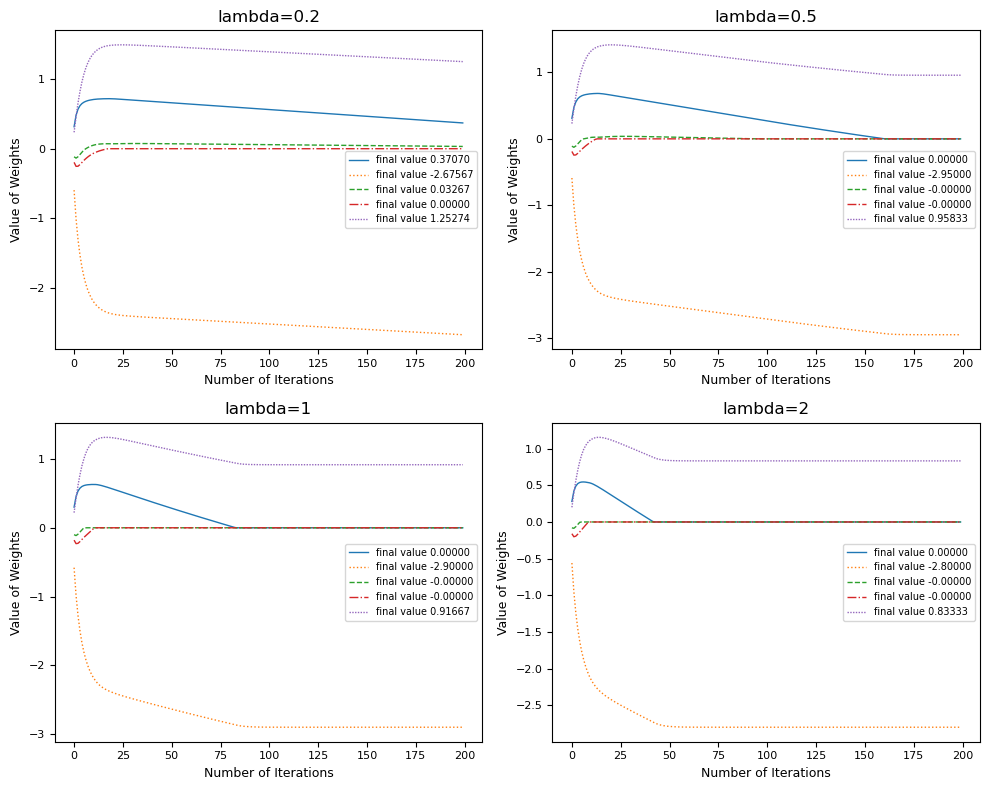

In [307]:
plot_many_w_vals_or_loss_vs_n_iters(num_epochs=n_epochs, w_init=w0, final_weights_list=weight_prox_list,
                                    weight_array_list=weight_arr_prox_list, loss_arr_lst=None,
                                    l1_reg_params=lambda_list, save_name_='lab1e_weight', save=True)

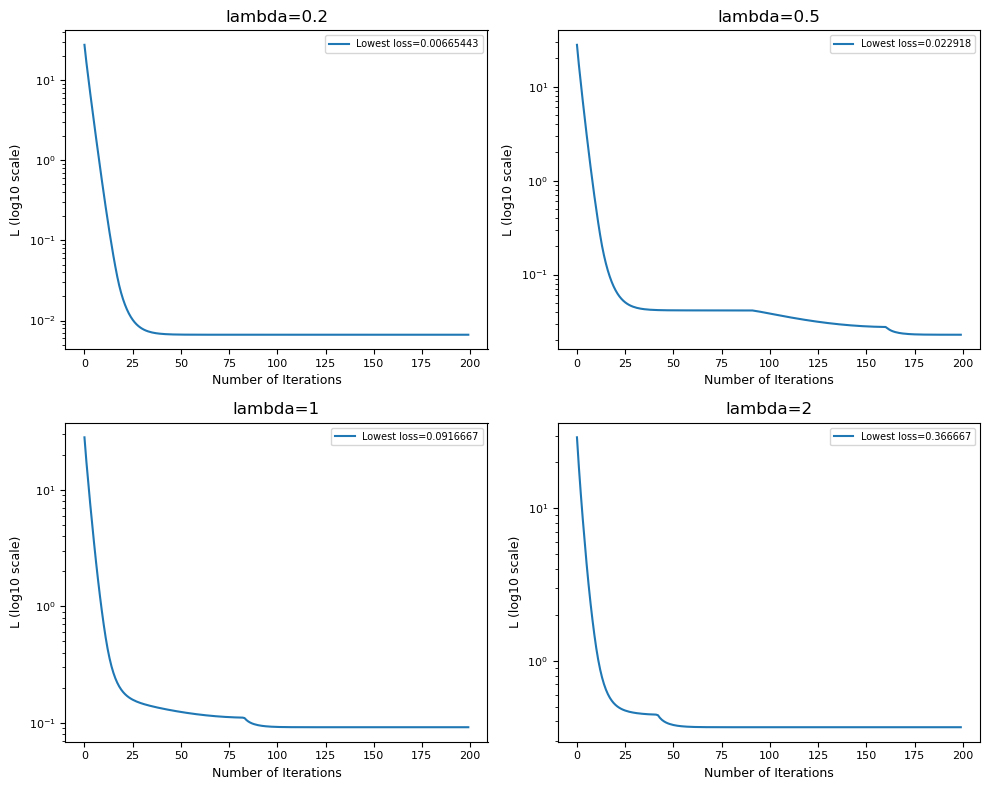

In [308]:
plot_many_w_vals_or_loss_vs_n_iters(num_epochs=n_epochs, w_init=w0, final_weights_list=None,
                                    weight_array_list=None, loss_arr_lst=loss_prox_list,
                                    l1_reg_params=lambda_list, save_name_='lab1e_loss', save=True)

In [309]:
"""(f) (6 pts) Trimmed l1 (Tl1) regulariser is proposed to solve the “bias” problem of l1. For simplicity you may implement the T l1 regulariser as applying a l1 regularization with strength λ on the 3 elements of W with the smallest absolute value, with no penalty on other elements. Minimize L + λT l1 (W ) using proximal gradient update with λ = {1.0, 2.0, 5.0, 10.0} (correspond the soft thresholding threshold {0.02, 0.04, 0.1, 0.2}). Plot the value of log(L) throughout the training, and use another figure to plot the value of each element in W in each step. Comment on the convergence comparison of the Trimmed l1 and the l1. Also compare the behavior of the early steps (e.g. first 20) between the Trimmed l1 and the iterative pruning."""
lambda_list_f = np.array([1.0, 2.0, 5.0, 10.0]) * 1

weight_trim_list, loss_trim_list, weight_arr_trim_list = [], [], []
for idx, lll in enumerate(lambda_list_f):
    w, l, w_array = run_grad_descent(w0, mu, x_input, y_input, n_epochs, w0_prune=False, thresh=2,
                                     l1_reg_param=lll, grad_fn=l1_norm_trimmed_update)
    weight_trim_list.append(w)
    loss_trim_list.append(l)
    weight_arr_trim_list.append(w_array)

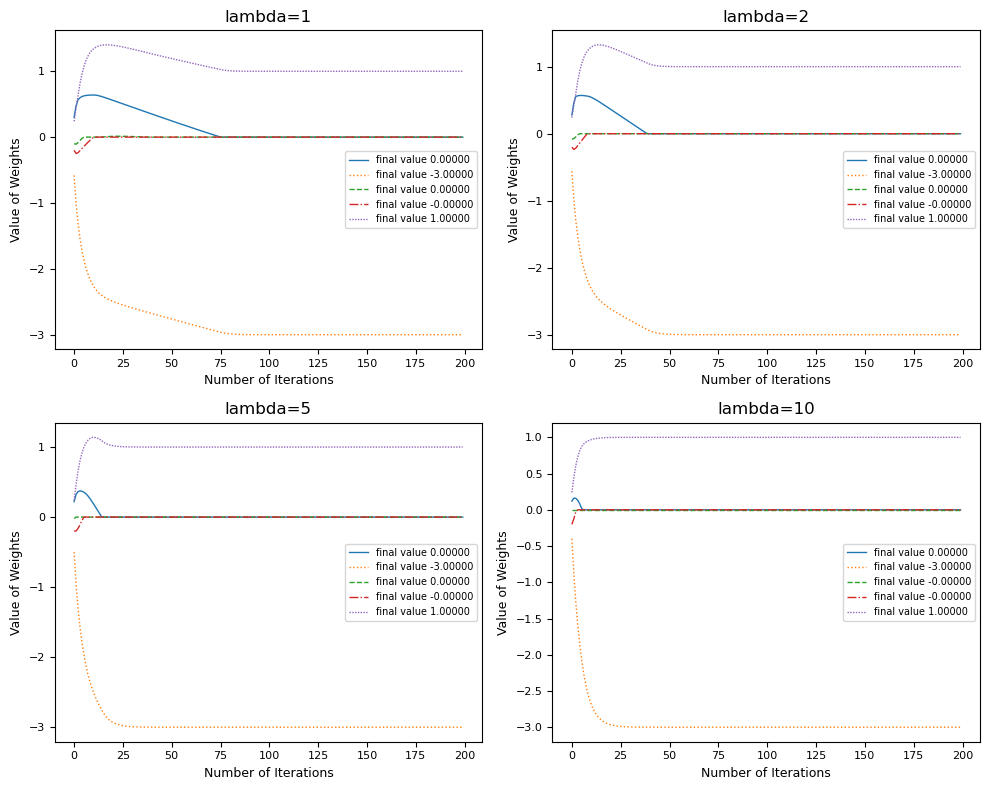

In [310]:
plot_many_w_vals_or_loss_vs_n_iters(num_epochs=n_epochs, w_init=w0, final_weights_list=weight_trim_list,
                                    weight_array_list=weight_arr_trim_list, loss_arr_lst=None,
                                    l1_reg_params=lambda_list_f, save_name_='lab1f_weight', save=True)

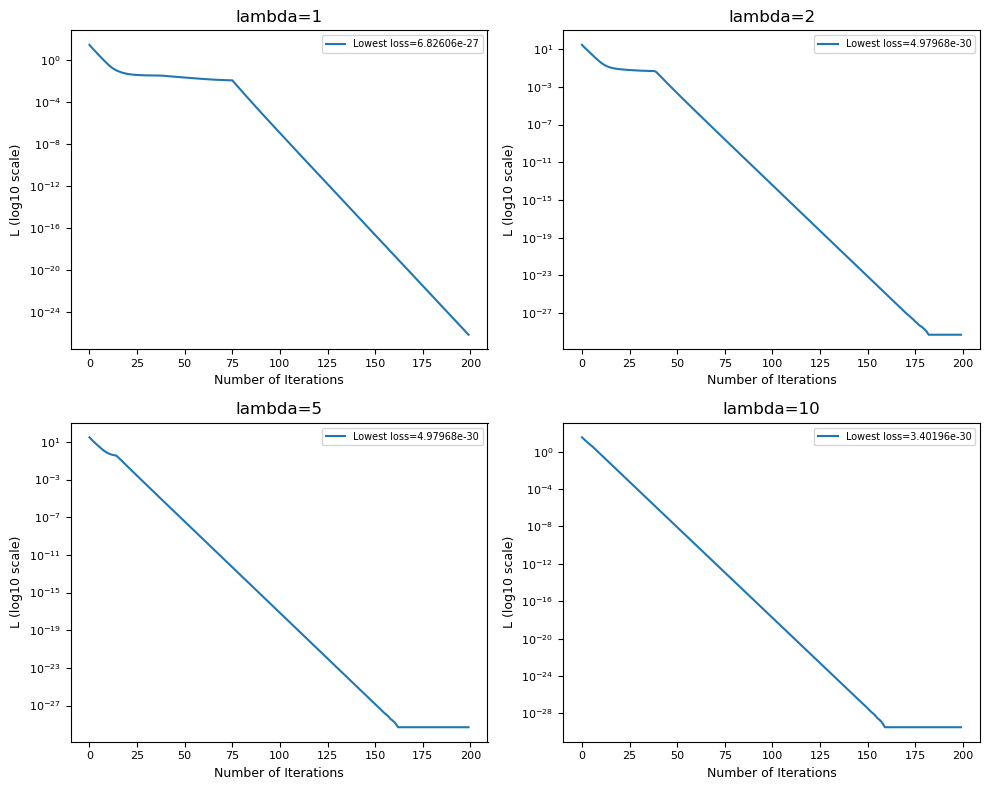

In [311]:
plot_many_w_vals_or_loss_vs_n_iters(num_epochs=n_epochs, w_init=w0, final_weights_list=None,
                                    weight_array_list=None, loss_arr_lst=loss_trim_list,
                                    l1_reg_params=lambda_list_f, save_name_='lab1f_loss', save=True)